# Data Analysis

## Setup

Import required modules

In [26]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter

from tapqir.models import SpotDetection
from tapqir.utils.dataset import GlimpseDataset, CosmosDataset, load_data
from pyro import param
from torch.distributions.utils import probs_to_logits, logits_to_probs
import torch.distributions.constraints as constraints

from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve, roc_auc_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## View Glimpse Images

Load glimpse files

In [27]:
path_data = "/shared/centaur/data/test/LarryCy3sigma54/"
glimpse = GlimpseDataset(path_data)
data = load_data(path_data, "test")
control = load_data(path_data, "control")

View target DNA sites

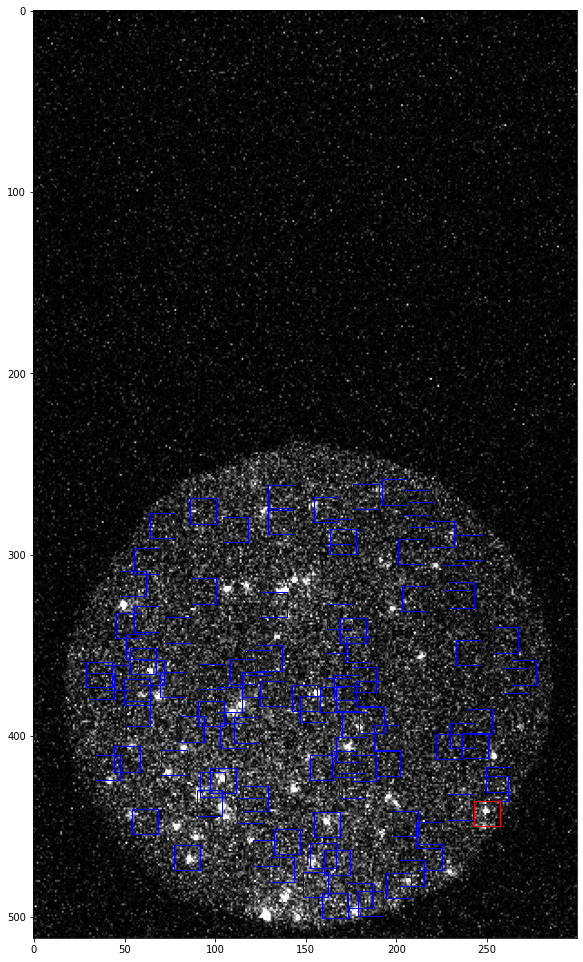

In [3]:
frame = data.drift.index[5]
plt.figure(figsize=(10, 10*glimpse.height/glimpse.width))
plt.imshow(glimpse[frame], cmap="gray", vmin=data.vmin, vmax=data.vmax)

for n in data.target.index:
    y_pos = data.target.at[n, "abs_y"] + data.drift.at[frame, "abs_dy"] - 7
    x_pos = data.target.at[n, "abs_x"] + data.drift.at[frame, "abs_dx"] - 7
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="b", facecolor="none"))
    #plt.gca().text(y_pos, x_pos, str(n), fontsize=10, color="white")

aoi = data.target.index[4]  
y_pos = data.target.at[aoi, "abs_y"] + data.drift.at[frame, "abs_dy"] - 7
x_pos = data.target.at[aoi, "abs_x"] + data.drift.at[frame, "abs_dx"] - 7
plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="r", facecolor="none"))
plt.show()

View non DNA sites

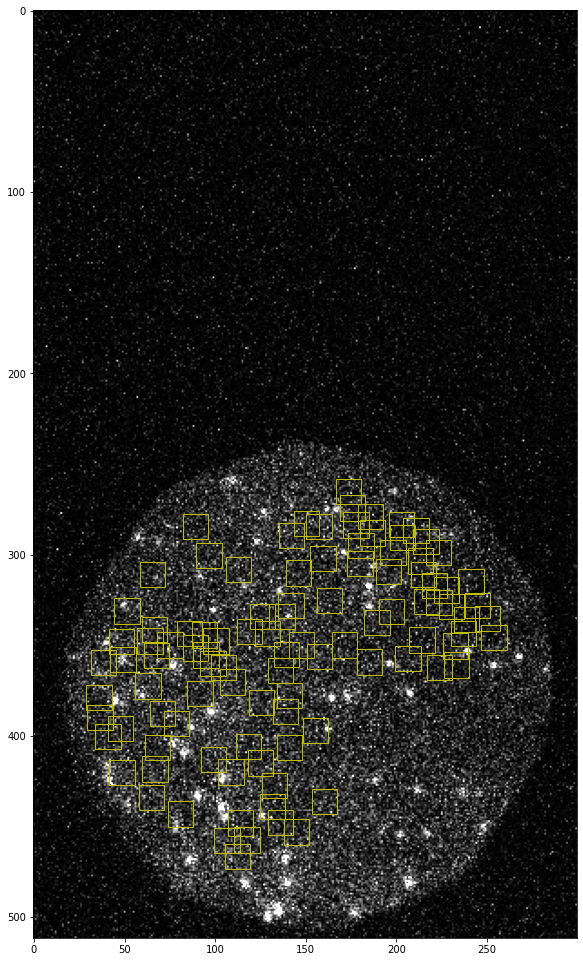

In [4]:
frame = data.drift.index[105]
plt.figure(figsize=(10, 10*glimpse.height/glimpse.width))
plt.imshow(glimpse[frame], cmap="gray", vmin=data.vmin, vmax=data.vmax)

for n in data.target.index:
    y_pos = control.target.at[n, "abs_y"] + control.drift.at[frame, "abs_dy"] - 7
    x_pos = control.target.at[n, "abs_x"] + control.drift.at[frame, "abs_dx"] - 7
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="y", facecolor="none"))

plt.show()

## Load parameters

In [28]:
path_params = os.path.join(path_data, "runs/spotdetection/v1.1.5/S1/nocontrol/lr0.005/bs2")
# load global parameters
results = pd.read_csv(
    os.path.join(path_params, "global_params.csv"),
    header=None, squeeze=True, index_col=0)
# load parameters
model = SpotDetection(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)
# load spotpicker labels
labels = np.load(os.path.join(path_data, "labels.npy"))

## Analysis

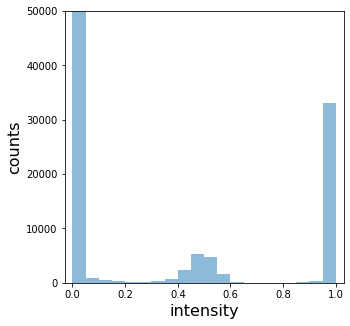

In [29]:
plt.figure(figsize=(5,5))
plt.hist(model.z_probs.flatten().numpy(),
         bins=20, alpha=0.5)
plt.ylim(0,50000)
plt.xlim(-0.03,1.03)
plt.ylabel("counts", fontsize=16)
plt.xlabel("intensity", fontsize=16)
plt.show()

### Intensity analysis

Intensity histogram (on-target spots)

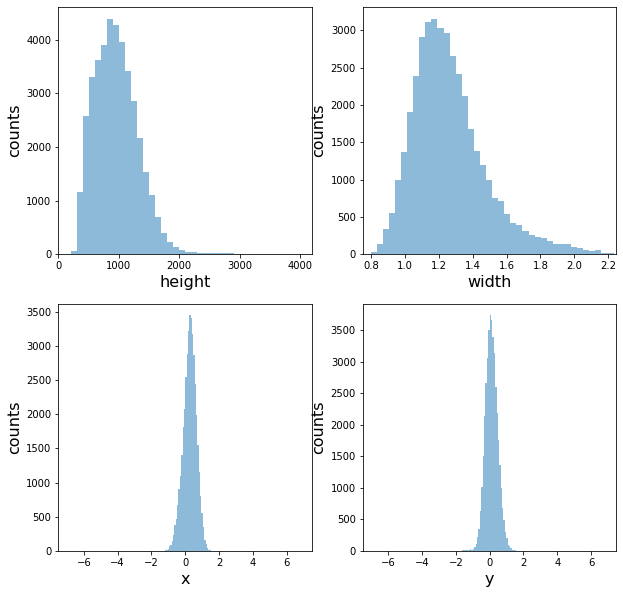

In [7]:
plt.figure(figsize=(10,10))
mask = model.z_probs > 0.5
plt.subplot(2,2,1)
plt.hist(param("d/h_loc").data[mask].numpy(),
         range=(0,4000), bins=40, alpha=0.5)
plt.xlim(0,)
plt.ylabel("counts", fontsize=16)
plt.xlabel("height", fontsize=16)

plt.subplot(2,2,2)
plt.hist(param("d/w_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(0.75,2.25)
plt.ylabel("counts", fontsize=16)
plt.xlabel("width", fontsize=16)

plt.subplot(2,2,3)
plt.hist(param("d/x_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(-7.5,7.5)
plt.ylabel("counts", fontsize=16)
plt.xlabel("x", fontsize=16)

plt.subplot(2,2,4)
plt.hist(param("d/y_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(-7.5,7.5)
plt.ylabel("counts", fontsize=16)
plt.xlabel("y", fontsize=16)
plt.show()

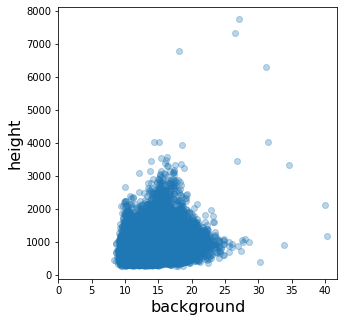

In [8]:
plt.figure(figsize=(5,5))
mask = model.z_probs > 0.5
plt.scatter(param("d/b_loc").data[mask.sum(0).bool()].numpy(), param("d/h_loc").data[mask].numpy(), alpha=0.3)
plt.xlim(0,)
plt.ylabel("height", fontsize=16)
plt.xlabel("background", fontsize=16)
plt.show()

### Binding rastergram

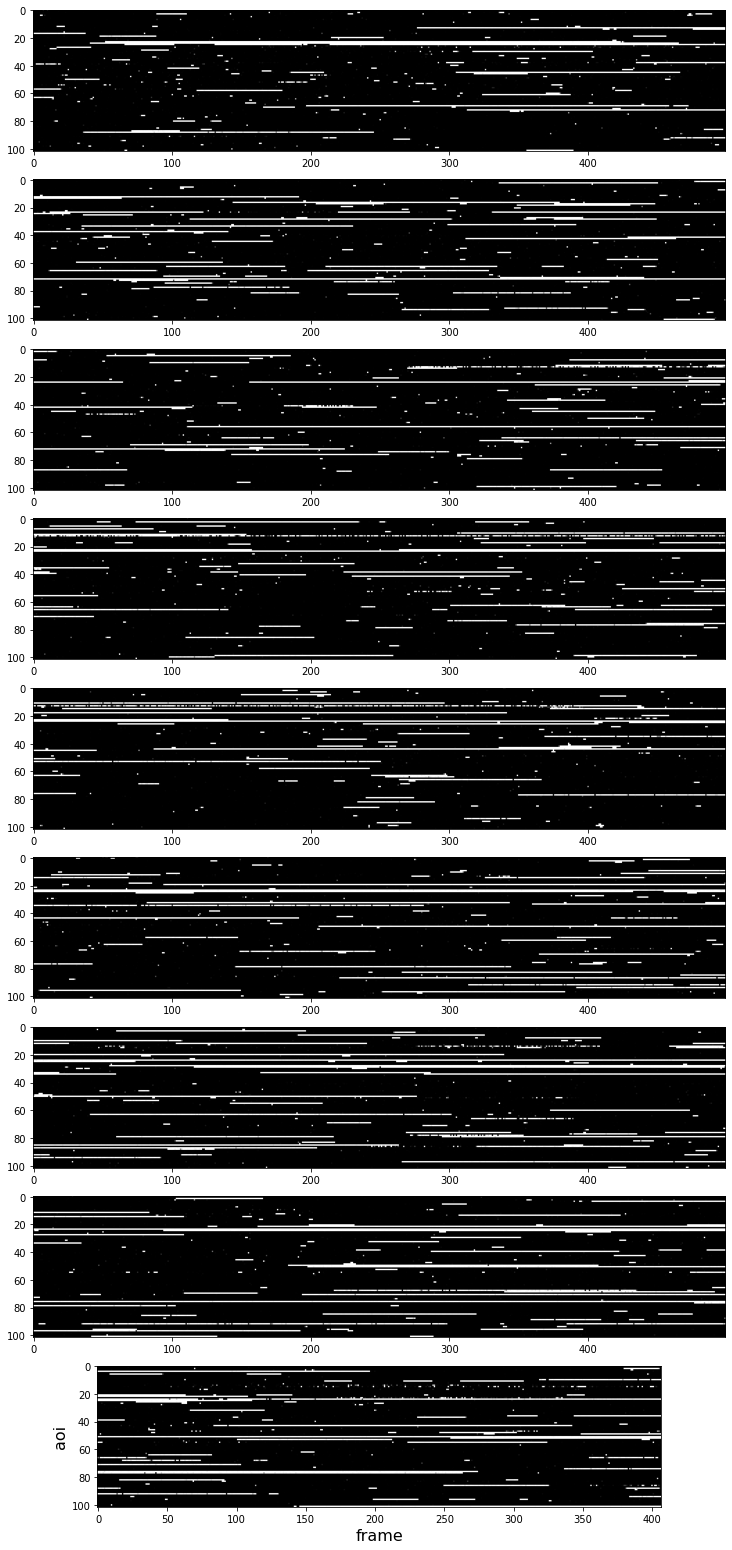

In [9]:
r = model.data.F // 500 + 1
figsize = torch.tensor([15, model.data.N * r * 15. / 500])
plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.z_marginal[:, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### Time to first binding

$$ \mathrm{ttfb} = \sum_{f=1}^{F-1} f z_{n,f} \prod_{f^\prime=0}^{f-1} (1 - z_{n,f^\prime})
    + F \prod_{f^\prime=0}^{F-1} (1 - z_{n,f^\prime}) $$

$$ \mathbb{E}[\mathrm{ttfb}] = \sum_{f=1}^{F-1} f q(z_{n,f}=1) \prod_{f^\prime=f-1}^{f-1} q(z_{n,f^\prime}=0)
    + F \prod_{f^\prime=0}^{F-1} q(z_{n,f^\prime}=0) $$

In [ ]:
# ttfb, on- off- dwell times bayesian vs spotpicker
# 

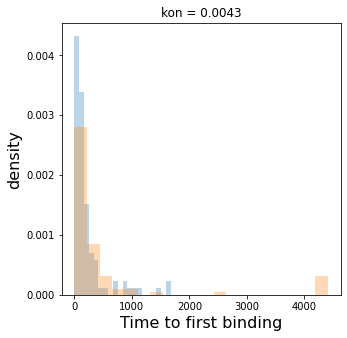

In [32]:
frames = torch.arange(1, model.data.F+1)
q1 = torch.ones(model.data.N, model.data.F)
q1[:, :-1] = model.z_marginal[:, 1:]
cumq0 = torch.cumprod(1 - model.z_marginal, dim=-1)
ttfb = (frames * q1 * cumq0).sum(-1)

plt.figure(figsize=(5,5))
plt.title("kon = {:.4f}".format(1/ttfb.mean()))
plt.hist(ttfb.numpy(), bins=20, density=True, alpha=0.3)
plt.hist(sttfb, bins=20, density=True, alpha=0.3)
plt.xlabel("Time to first binding", fontsize=16)
plt.ylabel("density", fontsize=16)
plt.show()

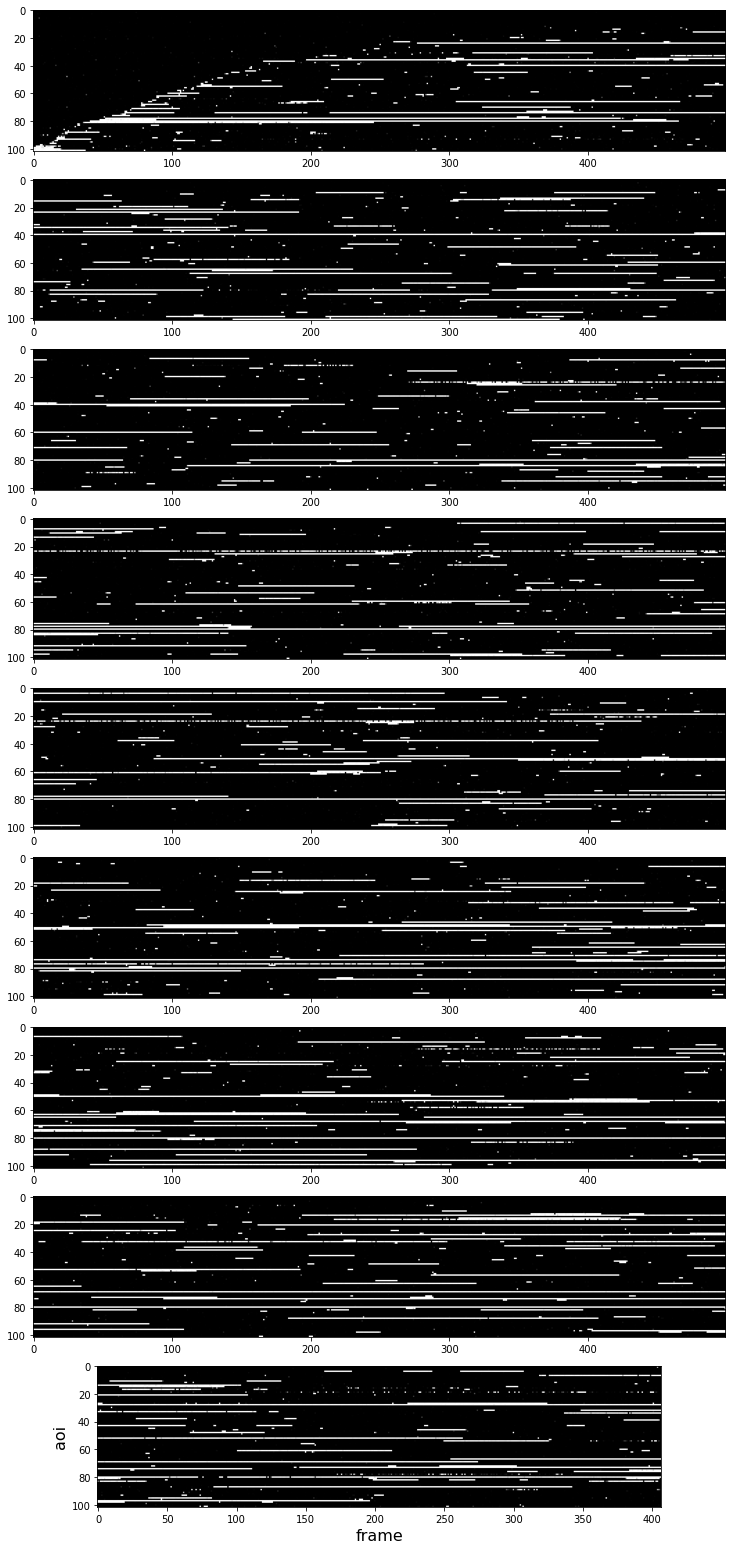

In [11]:
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.z_marginal[sdx, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### HMM analysis


$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

In [12]:
samples = dist.Bernoulli(model.z_marginal).sample((100,))

bind = (samples[..., :-1] < samples[..., 1:]).sum((-1))
dissociate = (samples[..., :-1] > samples[..., 1:]).sum(-1)

a01 = ((1 - samples[..., :-1]) * samples[..., 1:] / (1-samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[..., :-1]) * (1 - samples[..., 1:]) / (samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

sa01 = ((1 - model.data.labels["z"][:, :-1]) * model.data.labels["z"][:, 1:] / (1-model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))
sa10 = ((model.data.labels["z"][:, :-1]) * (1 - model.data.labels["z"][:, 1:]) / (model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))

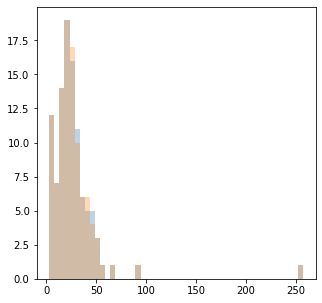

In [13]:
plt.figure(figsize=(5,5))
plt.hist(bind[0].numpy(), bins=50, alpha=0.3)
plt.hist(dissociate[0].numpy(), bins=50, alpha=0.3)
#plt.xlim(0,60)
plt.show()

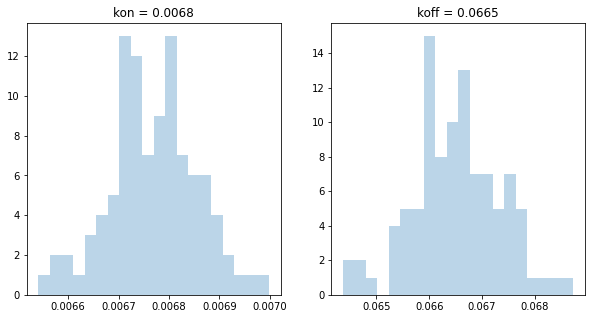

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

Let's find and remove high-frequency traces

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  """Entry point for launching an IPython kernel.


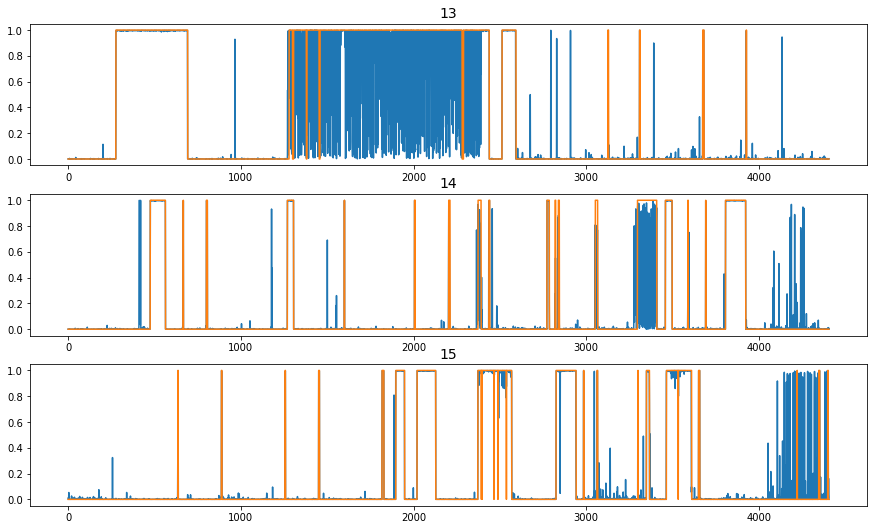

In [15]:
high_frequency = torch.nonzero(bind[0] > 60).squeeze()
r = len(high_frequency) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(high_frequency):
    plt.subplot(r,1,i+1)
    plt.title(n.item(), fontsize=14)
    plt.plot(model.z_marginal[n])
    plt.plot(model.data.labels["z"][n])
plt.show()

In [16]:
low_frequency = torch.nonzero(bind[0] <= 60).squeeze()
a01 = ((1 - samples[:, low_frequency, :-1]) * samples[:, low_frequency, 1:] / (1-samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[:, low_frequency, :-1]) * (1 - samples[:, low_frequency, 1:]) / (samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

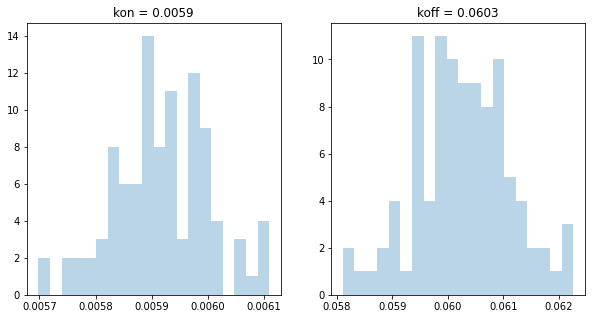

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

Now let's see how real data kinetics compares to the simulated kinetics from the best fit

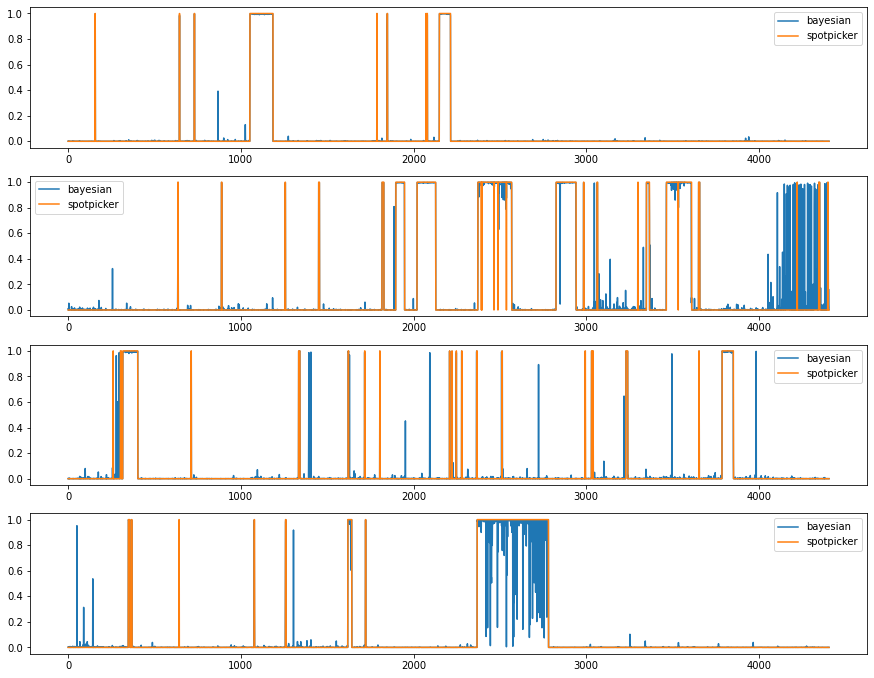

In [18]:
# look at 5, 15, 30, 35
examples = [5, 15, 30, 35]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    plt.plot(model.z_marginal[n], label="bayesian")
    plt.plot(model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

### Simulated trace

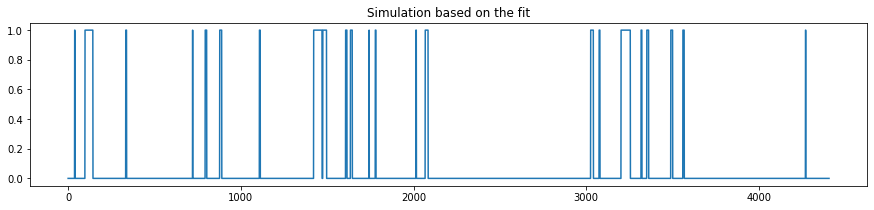

In [19]:
A = torch.tensor([[1-a01.mean(), a01.mean()], [a10.mean(), 1-a10.mean()]])

x = torch.zeros(model.data.F)
for i in range(1,model.data.F):
    x[i] = dist.Bernoulli(A[x[i-1].long()][1]).sample().item()

plt.figure(figsize=(15,3))
plt.title("Simulation based on the fit")
plt.plot(x)
plt.show()

### Spotpicker sorted rastergram

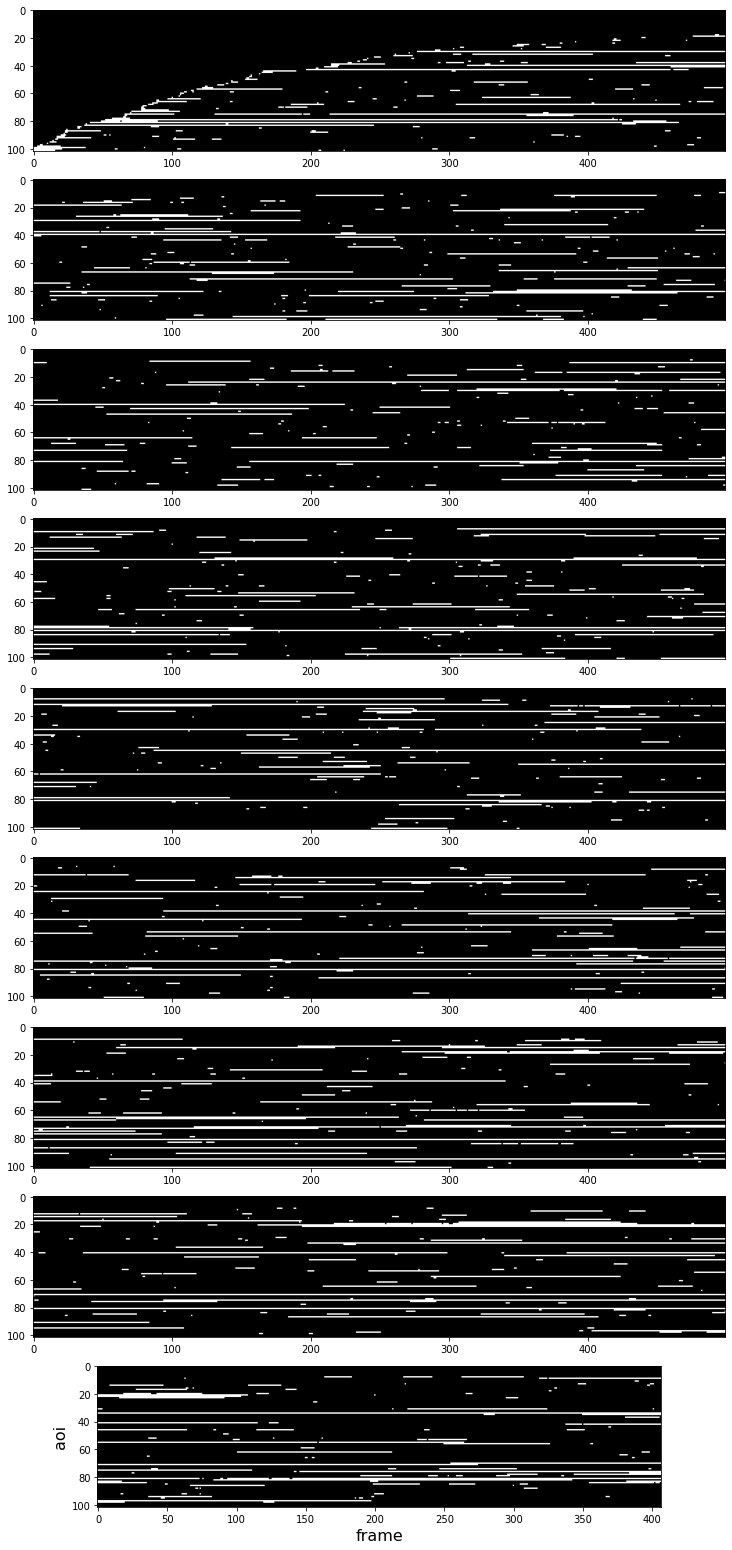

In [31]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
sdx = np.flip(np.argsort(sttfb))

r = model.data.F // 500 + 1
figsize = torch.tensor([15, model.data.N * r * 15. / 500])
plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.data.labels["z"][sdx, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### Differences

In [21]:
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))
n, f = np.nonzero(mask)
np.unique(n, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
         14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,  94,  96,
         97,  98,  99, 100, 101]),
 array([ 8,  4,  6,  7,  3,  1,  2,  3,  3,  5,  2,  1, 23, 36, 42,  8,  2,
         4,  3,  2,  1, 22,  9,  2,  7,  8,  2,  6, 15,  6,  2,  5,  3,  5,
         7,  3, 10,  4, 10,  5,  4,  3,  6,  7, 32,  3,  7,  1,  8,  7,  7,
         6, 11,  4,  5,  1,  1,  1,  5,  3,  9,  3,  8,  7, 22,  5,  3,  6,
         1,  7, 14,  2,  1,  5,  4,  2,  1,  1,  4,  3,  2,  5, 24,  1,  5,
         6,  2,  3,  3,  8,  1,  8,  8,  2,  9,  5]))

torch.Size([619, 14, 14])


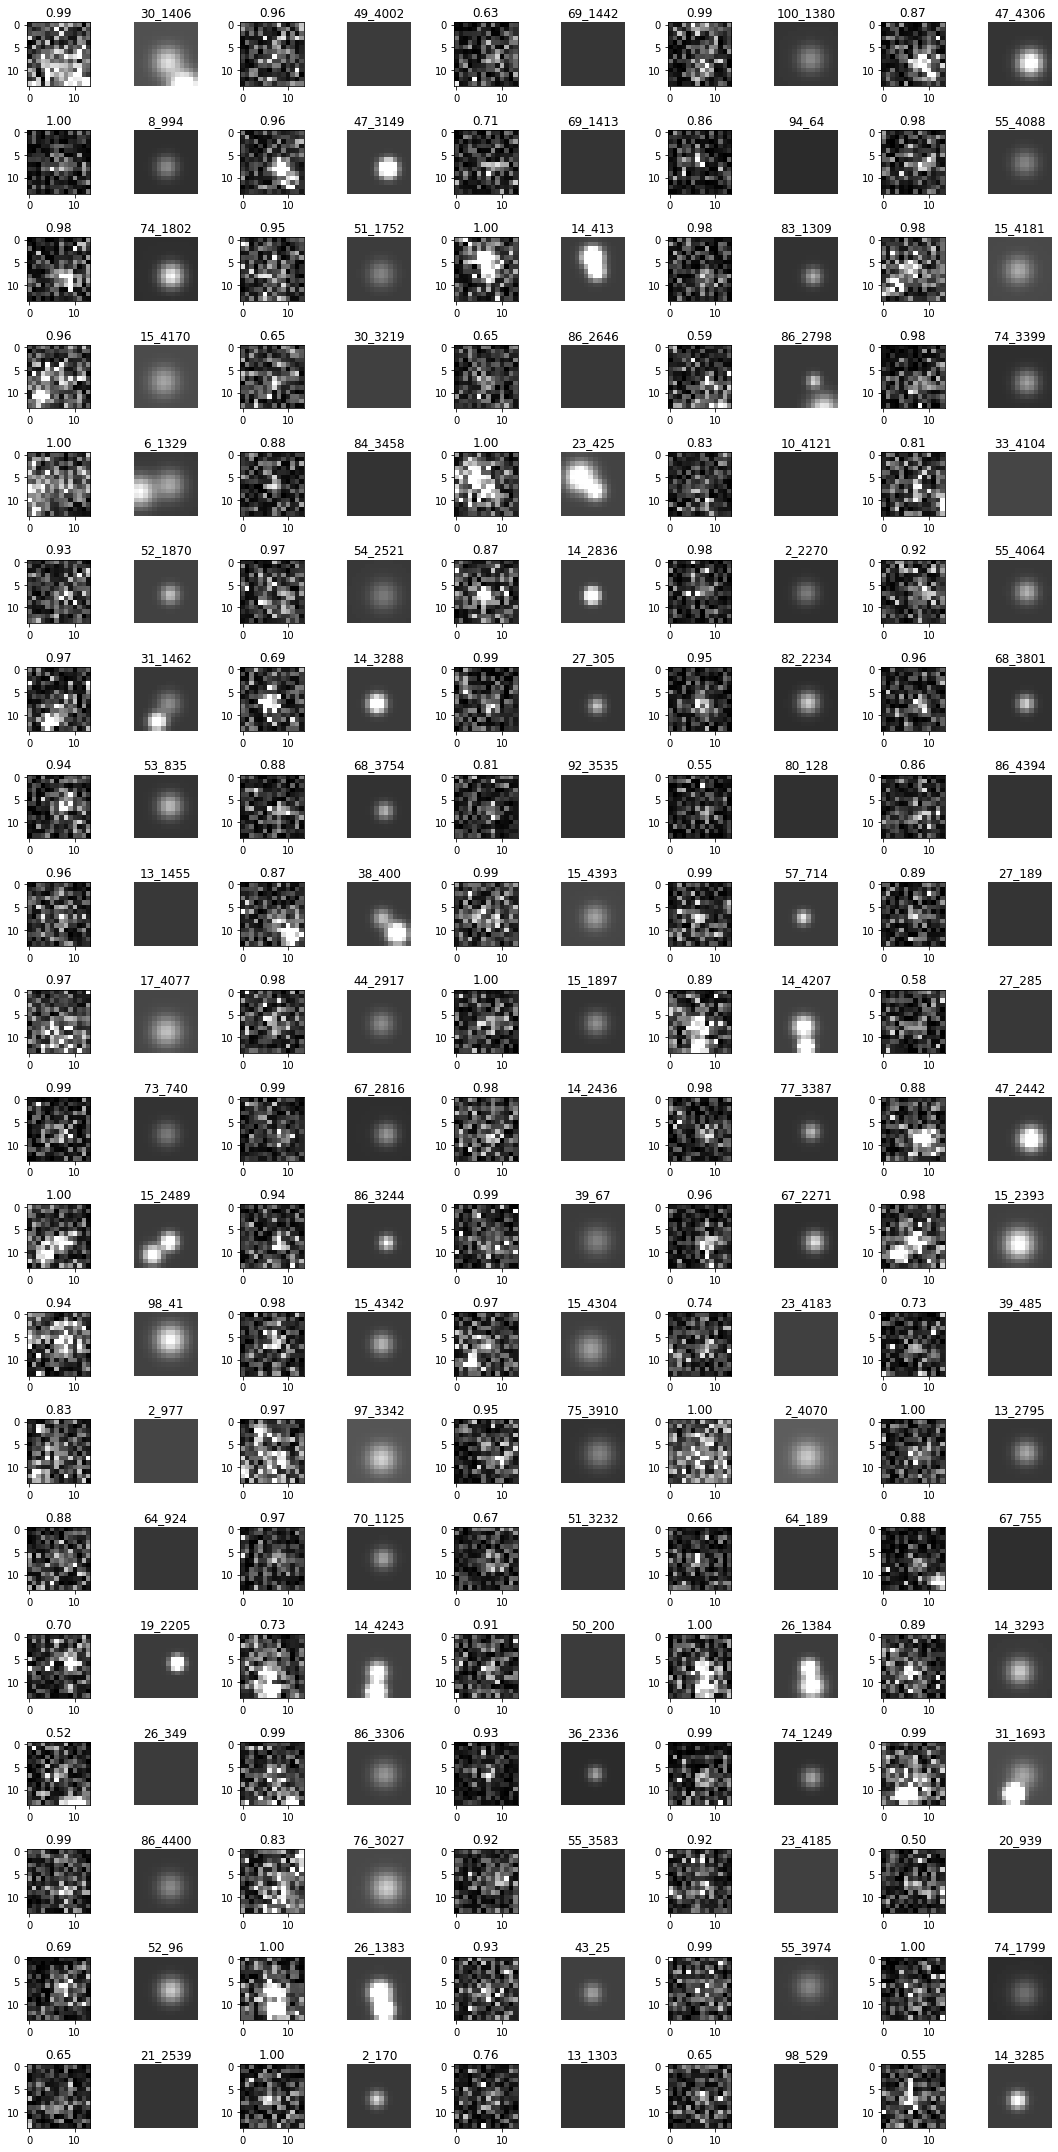

In [22]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[j], f[j]].masked_fill(model.m_probs[:, n[j], f[j]] < 0.5, 0.),
    param("d/w_mean").data[:, n[j], f[j]],
    param("d/x_mean").data[:, n[j], f[j]],
    param("d/y_mean").data[:, n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
mask = (((model.data.labels["z"] == 1) & (model.z_marginal.numpy() < 0.5)))
n, f = np.nonzero(mask)
np.unique(n, return_counts=True)

(array([  0,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  60,  62,  63,  64,  66,  67,  68,  69,  70,
         71,  73,  74,  75,  76,  77,  78,  79,  82,  83,  85,  86,  87,
         88,  89,  92,  93,  94,  96,  97,  98,  99, 100, 101]),
 array([  3,   3,  12,   6,   2,   6,   1,   1,  15,   9,   3, 315,  93,
          7,   1,   4,   6,   5,   7,   6,  24,  45,   9,   3,   4,   7,
          6,   7,   6,   2,   7,   1,  25,   1,   7,   3,   4,   7,  24,
          4,   5,  10,   5,   3,  22,   6,   5,   4,   9,   9,  24,   4,
          1,   2,   4,   6,   5,   7,   6,   7,  28,   3,  23,   4,   6,
          6,   4,  10,   4,   2,  14,  21,   9,   8,   5,   2,  11,   5,
         10,   5,  34,   6,   8,   6,   4,   9,   5,   4,  

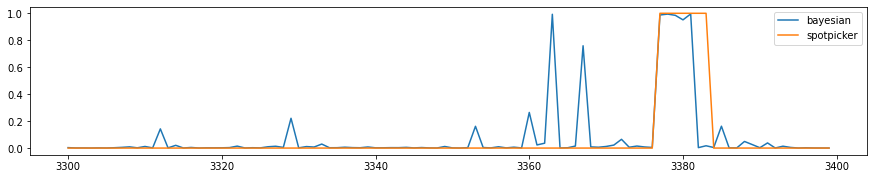

In [24]:
# look at 5, 15, 30, 35
examples = [51]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    f1 = 3300
    f2 = 3400
    plt.plot(torch.arange(f1, f2), model.z_marginal[n, f1:f2], label="bayesian")
    plt.plot(torch.arange(f1, f2), model.data.labels["z"][n, f1:f2], label="spotpicker")
    #plt.plot(torch.arange(model.data.F), model.z_marginal[n], label="bayesian")
    #plt.plot(torch.arange(model.data.F), model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

torch.Size([965, 14, 14])


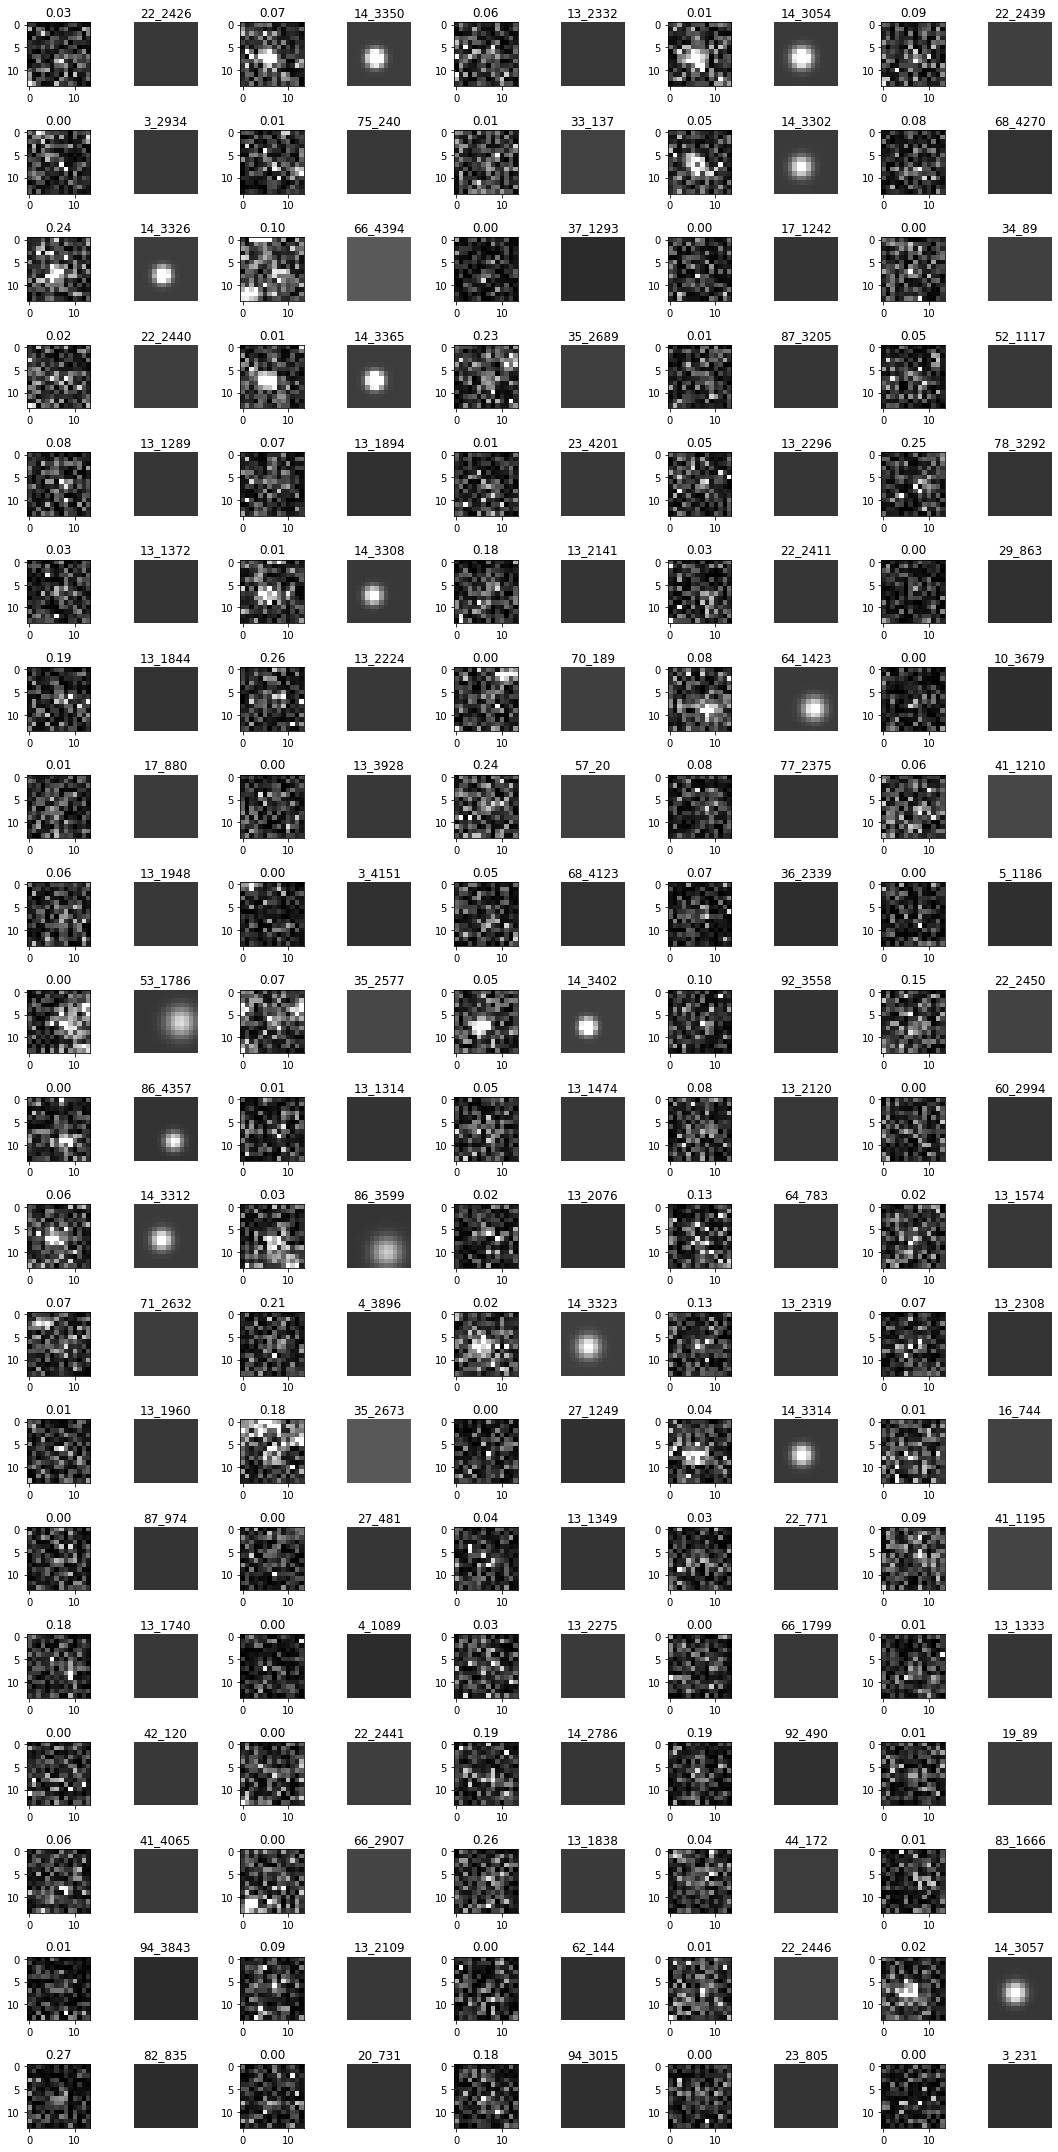

In [25]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 1) & (model.z_marginal.numpy() < 0.3)))

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[j], f[j]].masked_fill(model.m_probs[:, n[j], f[j]] < 0.5, 0.),
    param("d/w_mean").data[:, n[j], f[j]],
    param("d/x_mean").data[:, n[j], f[j]],
    param("d/y_mean").data[:, n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Appendix

$$ p(\mathbf{z}) = \prod_{n=0}^{N-1} p(z_{n,0}|\pi) \prod_{f=1}^{F-1} p(z_{n,f}|z_{n,f-1}, A) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( \log p(z_{n,0}|\pi) + \sum_{f=1}^{F-1} \log p(z_{n,f}|z_{n,f-1}, A_{01}, A_{10}) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - \frac{A_{01}}{2})
        + (1-z_{n,f-1}) z_{n,f} \log \frac{A_{01}}{2}
        + z_{n,f-1} (1 - z_{n,f}) \log \frac{1+A_{10}}{2}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - A_{01})
        + (1-z_{n,f-1}) z_{n,f} \log A_{01}
        + z_{n,f-1} (1 - z_{n,f}) \log A_{10}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial \pi}
 = \sum_{n=0}^{N-1} \left ( -\dfrac{1-z_{n,0}}{1-\pi} + \dfrac{z_{n,0}}{\pi} \right ) = 0 $$
 
$$ \sum_{n=0}^{N-1} \left ( \dfrac{(1-\pi) z_{n,0} - \pi (1-z_{n,0})}{\pi (1-\pi)} \right ) = 0 $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial A_{01}}
 = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left (
     \dfrac{-(1-z_{n,f-1})(1-z_{n,f})}{1-A_{01}}
     + \dfrac{(1-z_{n,f-1})z_{n,f}}{A_{01}} \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \left ( z_{n,0} - \pi \right ) = 0 $$

$$ \pi = \dfrac{1}{N} \sum_{n=0}^{N-1} z_{n,0} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ \pi \right ] = \dfrac{1}{N} \sum_{n=0}^{N-1} q(z_{n,0}=1) $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left ( (1-A_{01}) (1-z_{n,f-1})z_{n,f} - A_{01} (1-z_{n,f-1})(1-z_{n,f}) \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} - \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} $$

$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ A_{01} \right ]
    = \sum_\mathbf{z} \sum_n^N \sum_f^F \dfrac{(1-z_{n,f}) z_{n,f+1}}{\sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$

$$  = \sum_n^N \sum_f^F q(z_{n,f}=0) q(z_{n,f+1}=1) \sum_{\mathbf{z} \backslash z_{n,f},z_{n,f+1}}
    \dfrac{1}{1 + 0 + \sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$